# Sensitivity Analysis for Insurance Optimization

This notebook demonstrates the comprehensive sensitivity analysis tools for understanding how parameter changes affect optimization outcomes.

## Key Features:
- One-at-a-time (OAT) parameter analysis
- Tornado diagrams for impact ranking
- Two-way sensitivity heatmaps
- Efficient caching for repeated analyses
- Publication-ready visualizations

Author: Alex Filiakov  
Date: 2025-01-29

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent directory to path for imports
notebook_dir = Path.cwd()
project_root = notebook_dir.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Project imports
from src.sensitivity import (
    SensitivityAnalyzer,
    SensitivityResult,
    TwoWaySensitivityResult
)
from src.sensitivity_visualization import (
    plot_tornado_diagram,
    plot_two_way_sensitivity,
    plot_parameter_sweep,
    plot_sensitivity_matrix,
    create_sensitivity_report
)

# Import optimization components
from src.manufacturer import WidgetManufacturer
from src.business_optimizer import (
    BusinessOptimizer,
    BusinessConstraints,
    BusinessObjective,
    OptimizationDirection
)
from src.loss_distributions import LognormalLoss
from src.claim_generator import ClaimGenerator

print("✅ All imports successful!")

✅ All imports successful!


## 1. Setup Base Configuration

First, let's establish our baseline configuration for the manufacturing company and insurance parameters.

In [ ]:
# Base configuration for sensitivity analysis
base_config = {
    # Manufacturing parameters
    "initial_assets": 10_000_000,  # $10M starting assets
    "asset_turnover": 1.0,         # Revenue = 1x assets
    "base_operating_margin": 0.08,      # 8% operating margin
    "tax_rate": 0.25,              # 25% tax rate
    "working_capital_pct": 0.20,   # 20% of sales
    
    # Loss parameters (attritional)
    "loss_frequency": 5.0,         # 5 losses per year average
    "loss_severity_mean": 100_000, # $100K average loss
    "loss_severity_cv": 1.5,       # Coefficient of variation
    
    # Insurance parameters
    "premium_rate": 0.02,          # 2% of coverage
    "deductible": 50_000,          # $50K retention
    "coverage_limit": 5_000_000,   # $5M coverage
    
    # Optimization constraints
    "max_ruin_probability": 0.01,  # 1% max bankruptcy risk
    "min_roe_target": 0.15,        # 15% minimum ROE
    "max_premium_budget": 0.03,    # 3% of revenue max
}

print("Base Configuration:")
for key, value in base_config.items():
    if isinstance(value, float) and value < 1:
        print(f"  {key}: {value:.1%}")
    elif isinstance(value, (int, float)) and value > 1000:
        print(f"  {key}: ${value:,.0f}")
    else:
        print(f"  {key}: {value}")

Base Configuration:
  initial_assets: $10,000,000
  asset_turnover: 1.0
  operating_margin: 8.0%
  tax_rate: 25.0%
  working_capital_pct: 20.0%
  loss_frequency: 5.0
  loss_severity_mean: $100,000
  loss_severity_cv: 1.5
  premium_rate: 2.0%
  deductible: $50,000
  coverage_limit: $5,000,000
  max_ruin_probability: 1.0%
  min_roe_target: 15.0%
  max_premium_budget: 3.0%


## 2. Create Mock Optimizer for Demonstration

For this demonstration, we'll create a simplified optimizer that provides deterministic results based on the configuration. In production, this would be replaced with the actual BusinessOptimizer.

In [ ]:
from dataclasses import dataclass

@dataclass
class OptimizationResult:
    """Simplified optimization result for demonstration."""
    @dataclass
    class Strategy:
        expected_roe: float
        bankruptcy_risk: float
        growth_rate: float
        capital_efficiency: float
        deductible: float
        premium_rate: float
    
    def __init__(self, config):
        # Create realistic results based on configuration
        freq = config.get('loss_frequency', 5)
        sev = config.get('loss_severity_mean', 100000)
        prem = config.get('premium_rate', 0.02)
        ded = config.get('deductible', 50000)
        margin = config.get('base_operating_margin', 0.08)
        
        # Simple model: higher frequency/severity = lower ROE, higher risk
        base_roe = margin * 2  # Leverage effect
        freq_impact = (5 - freq) * 0.01  # Lower frequency = higher ROE
        sev_impact = (100000 - sev) / 1000000  # Lower severity = higher ROE
        prem_impact = -prem * 2  # Premium cost reduces ROE
        
        self.optimal_strategy = self.Strategy(
            expected_roe=max(0.05, min(0.30, base_roe + freq_impact + sev_impact + prem_impact)),
            bankruptcy_risk=max(0.001, min(0.05, freq * sev / 100000000)),
            growth_rate=max(0.02, min(0.15, margin * 0.8)),
            capital_efficiency=0.75 + margin,
            deductible=ded,
            premium_rate=prem
        )

class DemoOptimizer:
    """Simplified optimizer for demonstration."""
    
    def optimize(self, config):
        """Run optimization with given configuration."""
        return OptimizationResult(config)

# Create optimizer instance
optimizer = DemoOptimizer()

# Test the optimizer
test_result = optimizer.optimize(base_config)
print(f"Test optimization result:")
print(f"  Expected ROE: {test_result.optimal_strategy.expected_roe:.1%}")
print(f"  Bankruptcy Risk: {test_result.optimal_strategy.bankruptcy_risk:.2%}")
print(f"  Growth Rate: {test_result.optimal_strategy.growth_rate:.1%}")

Test optimization result:
  Expected ROE: 12.0%
  Bankruptcy Risk: 0.50%
  Growth Rate: 6.4%


## 3. Initialize Sensitivity Analyzer

Create the sensitivity analyzer with caching enabled for efficient repeated analyses.

In [4]:
# Create cache directory for persistent caching
cache_dir = Path("cache/sensitivity")
cache_dir.mkdir(parents=True, exist_ok=True)

# Initialize analyzer
analyzer = SensitivityAnalyzer(
    base_config=base_config,
    optimizer=optimizer,
    cache_dir=cache_dir
)

print(f"✅ Sensitivity analyzer initialized")
print(f"   Cache directory: {cache_dir}")
print(f"   Base configuration has {len(base_config)} parameters")

✅ Sensitivity analyzer initialized
   Cache directory: cache\sensitivity
   Base configuration has 14 parameters


## 4. One-at-a-Time (OAT) Sensitivity Analysis

Analyze how individual parameters affect the optimization outcomes.

In [5]:
# Analyze loss frequency sensitivity
freq_result = analyzer.analyze_parameter(
    "loss_frequency",
    param_range=(3, 8),  # 3-8 losses per year
    n_points=11
)

print("Loss Frequency Sensitivity Analysis:")
print(f"  Parameter: {freq_result.parameter}")
print(f"  Baseline: {freq_result.baseline_value:.1f} losses/year")
print(f"  Range: {freq_result.variations[0]:.1f} - {freq_result.variations[-1]:.1f}")
print(f"\nImpact on metrics:")
for metric in ['optimal_roe', 'bankruptcy_risk', 'growth_rate']:
    impact = freq_result.calculate_impact(metric)
    min_val, max_val = freq_result.get_metric_bounds(metric)
    print(f"  {metric}: elasticity = {impact:.3f}, range = [{min_val:.3f}, {max_val:.3f}]")

Loss Frequency Sensitivity Analysis:
  Parameter: loss_frequency
  Baseline: 5.0 losses/year
  Range: 3.0 - 8.0

Impact on metrics:
  optimal_roe: elasticity = 0.435, range = [0.090, 0.140]
  bankruptcy_risk: elasticity = 0.909, range = [0.003, 0.008]
  growth_rate: elasticity = 0.000, range = [0.064, 0.064]


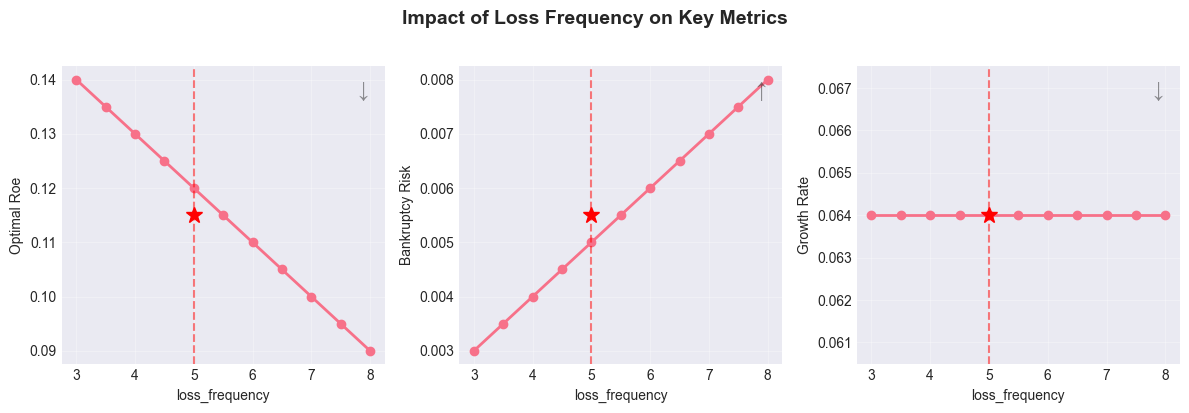

In [6]:
# Visualize parameter sweep
fig = plot_parameter_sweep(
    freq_result,
    metrics=['optimal_roe', 'bankruptcy_risk', 'growth_rate'],
    title="Impact of Loss Frequency on Key Metrics",
    figsize=(12, 4),
    mark_baseline=True
)
plt.tight_layout()
plt.show()

## 5. Tornado Diagram Analysis

Create a tornado diagram to rank parameters by their impact on the objective.

In [ ]:
# Define key parameters to analyze
key_parameters = [
    "loss_frequency",
    "loss_severity_mean",
    "loss_severity_cv",
    "premium_rate",
    "deductible",
    "base_operating_margin",
    "asset_turnover",
    "working_capital_pct"
]

# Generate tornado diagram data
print("Analyzing parameter sensitivities...")
tornado_data = analyzer.create_tornado_diagram(
    parameters=key_parameters,
    metric="optimal_roe",
    relative_range=0.3,  # ±30% from baseline
    n_points=5  # Use 5 points for speed
)

print("\nParameter Impact Ranking:")
for idx, row in tornado_data.iterrows():
    print(f"  {idx+1}. {row['parameter']:20s} Impact: {row['impact']:.3f} ({row['direction']})"
          f" Range: [{row['low_value']:.3f}, {row['high_value']:.3f}]")

Analyzing parameter sensitivities...

Parameter Impact Ranking:
  6. operating_margin     Impact: 1.333 (positive) Range: [0.072, 0.168]
  2. loss_severity_mean   Impact: 0.833 (positive) Range: [0.090, 0.150]
  1. loss_frequency       Impact: 0.417 (positive) Range: [0.105, 0.135]
  4. premium_rate         Impact: 0.333 (positive) Range: [0.108, 0.132]
  3. loss_severity_cv     Impact: 0.000 (negative) Range: [0.120, 0.120]
  5. deductible           Impact: 0.000 (negative) Range: [0.120, 0.120]
  7. asset_turnover       Impact: 0.000 (negative) Range: [0.120, 0.120]
  8. working_capital_pct  Impact: 0.000 (negative) Range: [0.120, 0.120]


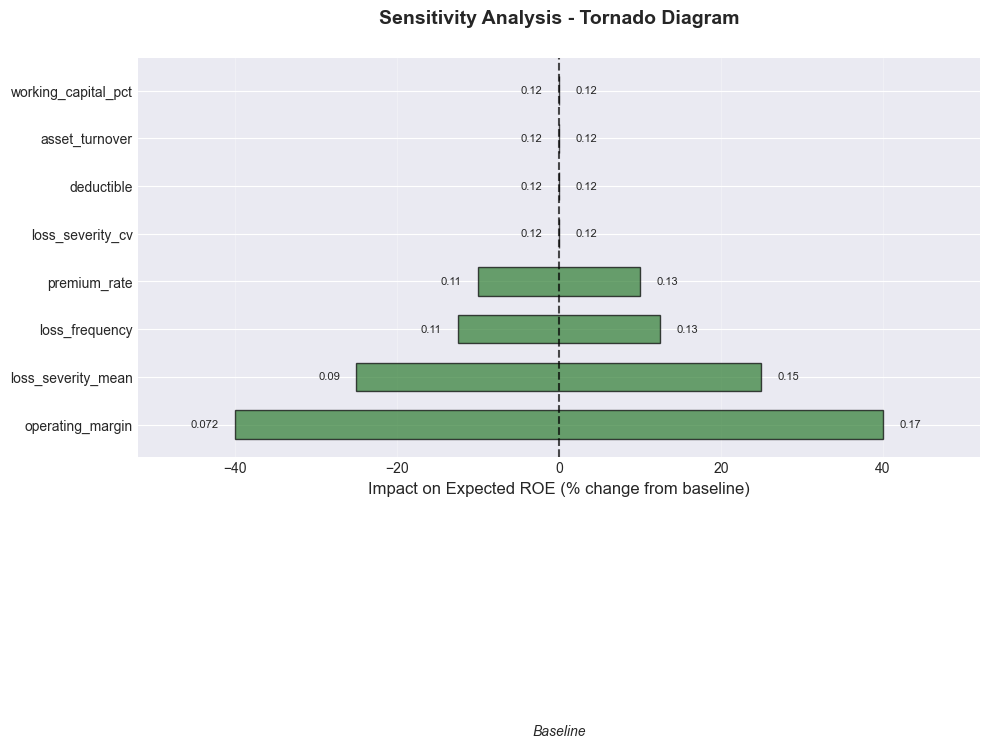

In [8]:
# Create tornado diagram visualization
fig = plot_tornado_diagram(
    tornado_data,
    title="Sensitivity Analysis - Tornado Diagram",
    metric_label="Impact on Expected ROE",
    figsize=(10, 6),
    n_params=8,  # Show top 8 parameters
    show_values=True
)
plt.tight_layout()
plt.show()

## 6. Two-Way Sensitivity Analysis

Analyze the interaction between two parameters and their combined effect on outcomes.

In [9]:
# Analyze frequency vs severity interaction
two_way_result = analyzer.analyze_two_way(
    param1="loss_frequency",
    param2="loss_severity_mean",
    param1_range=(3, 8),
    param2_range=(50000, 200000),
    n_points1=8,
    n_points2=8,
    metric="optimal_roe"
)

print(f"Two-Way Sensitivity Analysis:")
print(f"  Parameter 1: {two_way_result.parameter1}")
print(f"  Parameter 2: {two_way_result.parameter2}")
print(f"  Metric: {two_way_result.metric_name}")
print(f"  Grid size: {two_way_result.metric_grid.shape}")
print(f"  ROE range: [{two_way_result.metric_grid.min():.3f}, {two_way_result.metric_grid.max():.3f}]")

Two-Way Sensitivity Analysis:
  Parameter 1: loss_frequency
  Parameter 2: loss_severity_mean
  Metric: optimal_roe
  Grid size: (8, 8)
  ROE range: [0.050, 0.190]


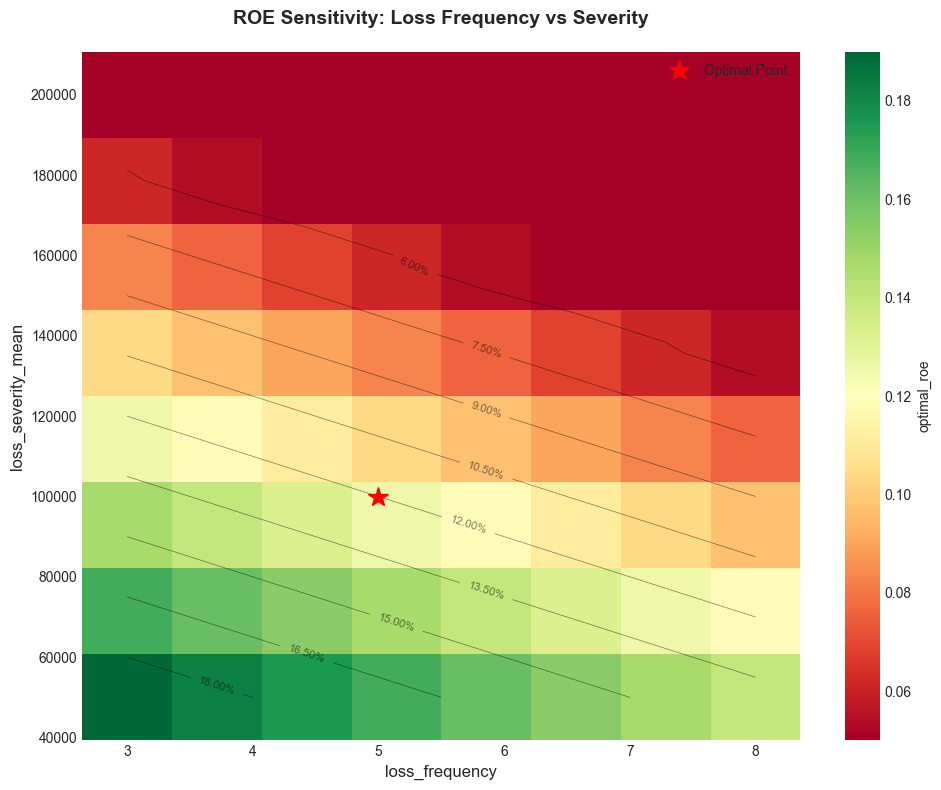

In [10]:
# Visualize two-way sensitivity
fig = plot_two_way_sensitivity(
    two_way_result,
    title="ROE Sensitivity: Loss Frequency vs Severity",
    cmap='RdYlGn',
    figsize=(10, 8),
    show_contours=True,
    contour_levels=10,
    optimal_point=(5.0, 100000),  # Mark baseline
    fmt='.2%'
)
plt.tight_layout()
plt.show()


Feasibility Analysis:
  Target ROE: 15.0%
  Feasible combinations: 10/64 (15.6%)


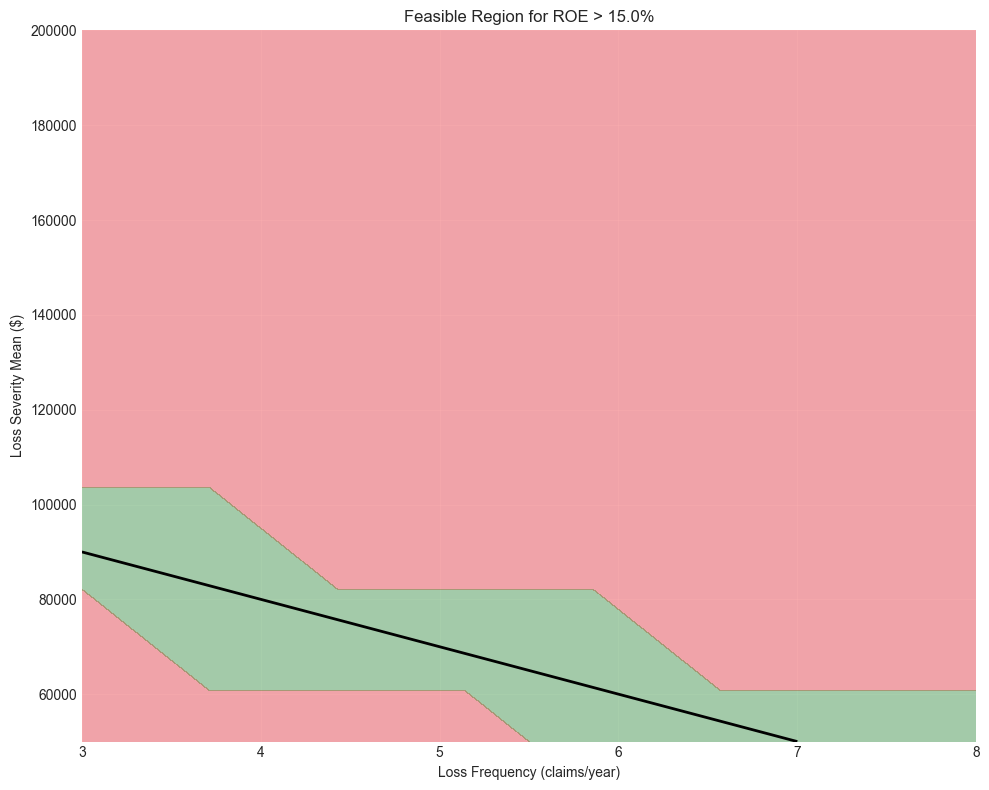

In [11]:
# Find optimal regions - where ROE > 15%
target_roe = 0.15
optimal_mask = two_way_result.find_optimal_region(target_roe, tolerance=0.1)

# Count feasible combinations
n_feasible = optimal_mask.sum()
n_total = optimal_mask.size
print(f"\nFeasibility Analysis:")
print(f"  Target ROE: {target_roe:.1%}")
print(f"  Feasible combinations: {n_feasible}/{n_total} ({100*n_feasible/n_total:.1f}%)")

# Show feasible region
fig, ax = plt.subplots(figsize=(10, 8))
X, Y = np.meshgrid(two_way_result.values1, two_way_result.values2, indexing='ij')
ax.contourf(X, Y, optimal_mask.astype(float), levels=[0, 0.5, 1], 
            colors=['red', 'green'], alpha=0.3)
ax.contour(X, Y, two_way_result.metric_grid, levels=[target_roe], 
           colors='black', linewidths=2)
ax.set_xlabel('Loss Frequency (claims/year)')
ax.set_ylabel('Loss Severity Mean ($)')
ax.set_title(f'Feasible Region for ROE > {target_roe:.1%}')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Parameter Group Analysis

Analyze multiple parameters simultaneously to understand their relative importance.

In [12]:
# Define parameter groups for analysis
loss_parameters = {
    "loss_frequency": (3, 8),
    "loss_severity_mean": (50000, 200000),
    "loss_severity_cv": (1.0, 2.0)
}

insurance_parameters = {
    "premium_rate": (0.01, 0.04),
    "deductible": (25000, 100000),
    "coverage_limit": (2500000, 10000000)
}

# Analyze loss parameters
print("Analyzing loss parameter group...")
loss_results = analyzer.analyze_parameter_group(
    loss_parameters,
    n_points=7,
    metric="optimal_roe"
)

# Analyze insurance parameters  
print("Analyzing insurance parameter group...")
insurance_results = analyzer.analyze_parameter_group(
    insurance_parameters,
    n_points=7,
    metric="optimal_roe"
)

print("\nAnalysis complete!")
print(f"  Loss parameters analyzed: {len(loss_results)}")
print(f"  Insurance parameters analyzed: {len(insurance_results)}")

Analyzing loss parameter group...
Analyzing insurance parameter group...

Analysis complete!
  Loss parameters analyzed: 3
  Insurance parameters analyzed: 3


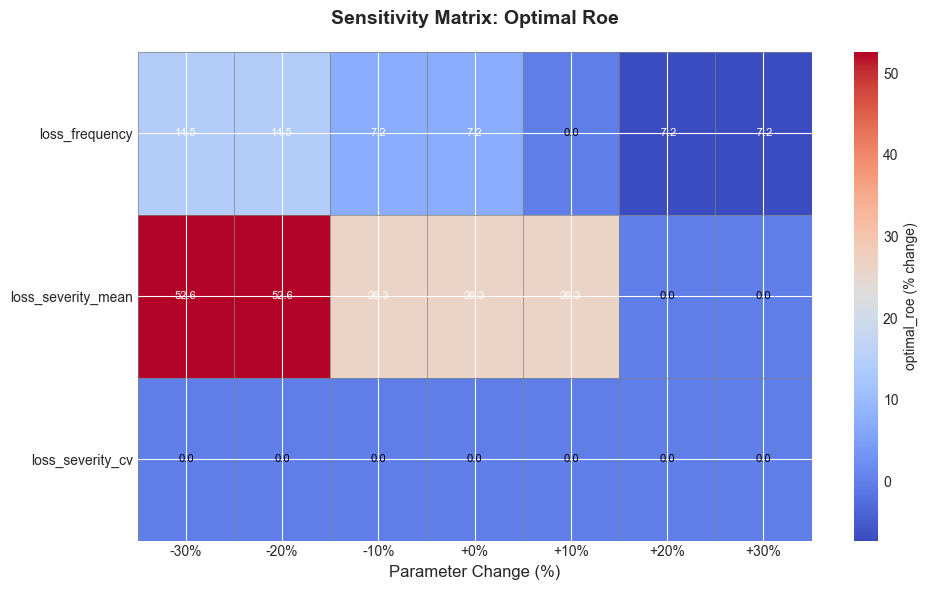

In [13]:
# Create sensitivity matrix for loss parameters
fig = plot_sensitivity_matrix(
    loss_results,
    metric="optimal_roe",
    figsize=(10, 6),
    cmap='coolwarm',
    show_values=True
)
plt.tight_layout()
plt.show()

## 8. Complete Sensitivity Report

Generate a comprehensive sensitivity report with all visualizations.

Generating comprehensive sensitivity report...
Generating tornado diagram...
Saved: results\sensitivity_analysis\tornado_diagram.png
Analyzing parameter: loss_severity_mean


Saved: results\sensitivity_analysis\sweep_loss_severity_mean.png
Analyzing parameter: loss_frequency
Saved: results\sensitivity_analysis\sweep_loss_frequency.png
Analyzing parameter: premium_rate
Saved: results\sensitivity_analysis\sweep_premium_rate.png
Sensitivity report generation complete!

📊 Report Summary:
  Most impactful parameter: loss_severity_mean
  Least impactful parameter: deductible
  Total parameters analyzed: 5

  Relative Importance:
    loss_severity_mean  : 52.6%
    loss_frequency      : 26.3%
    premium_rate        : 21.1%

✅ Report saved to: results\sensitivity_analysis


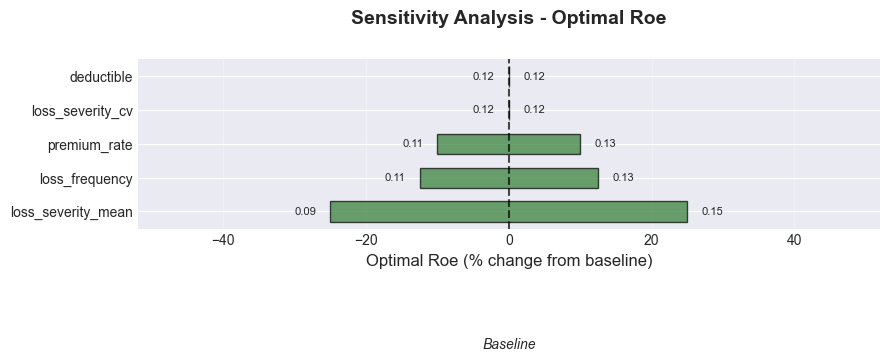

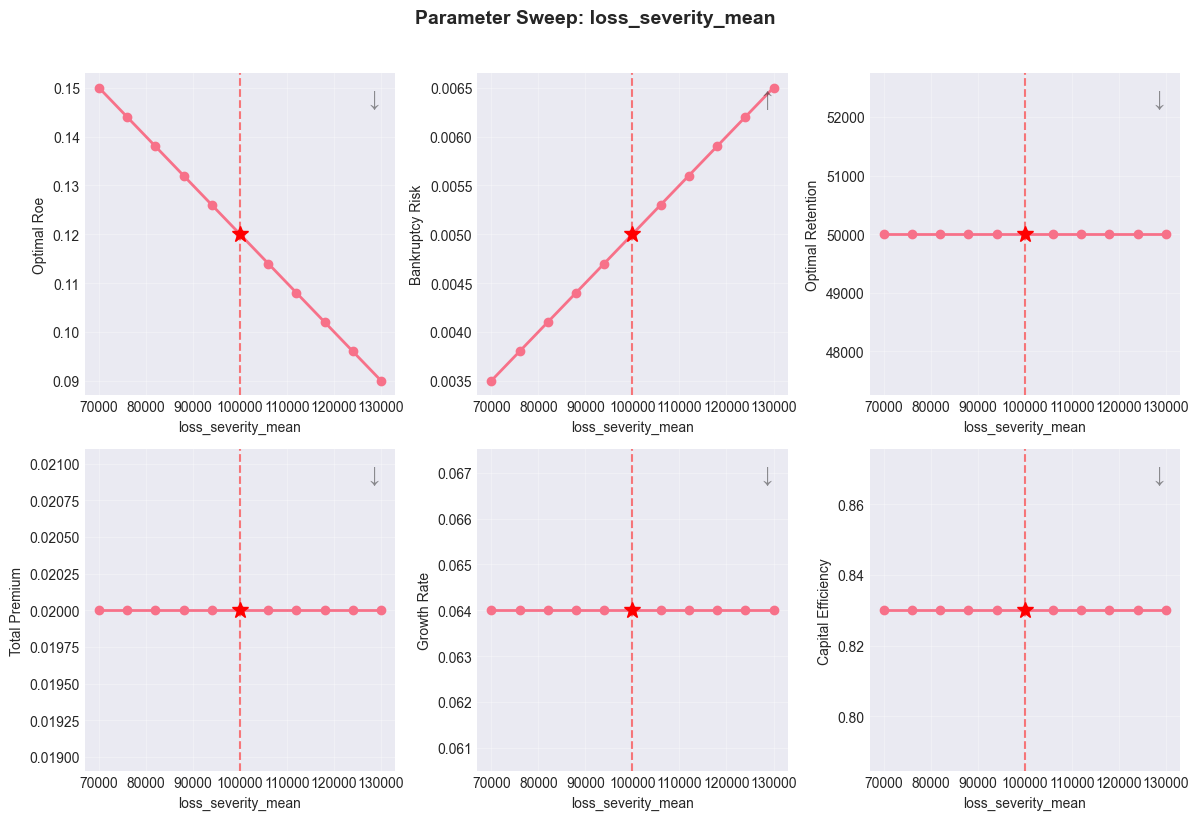

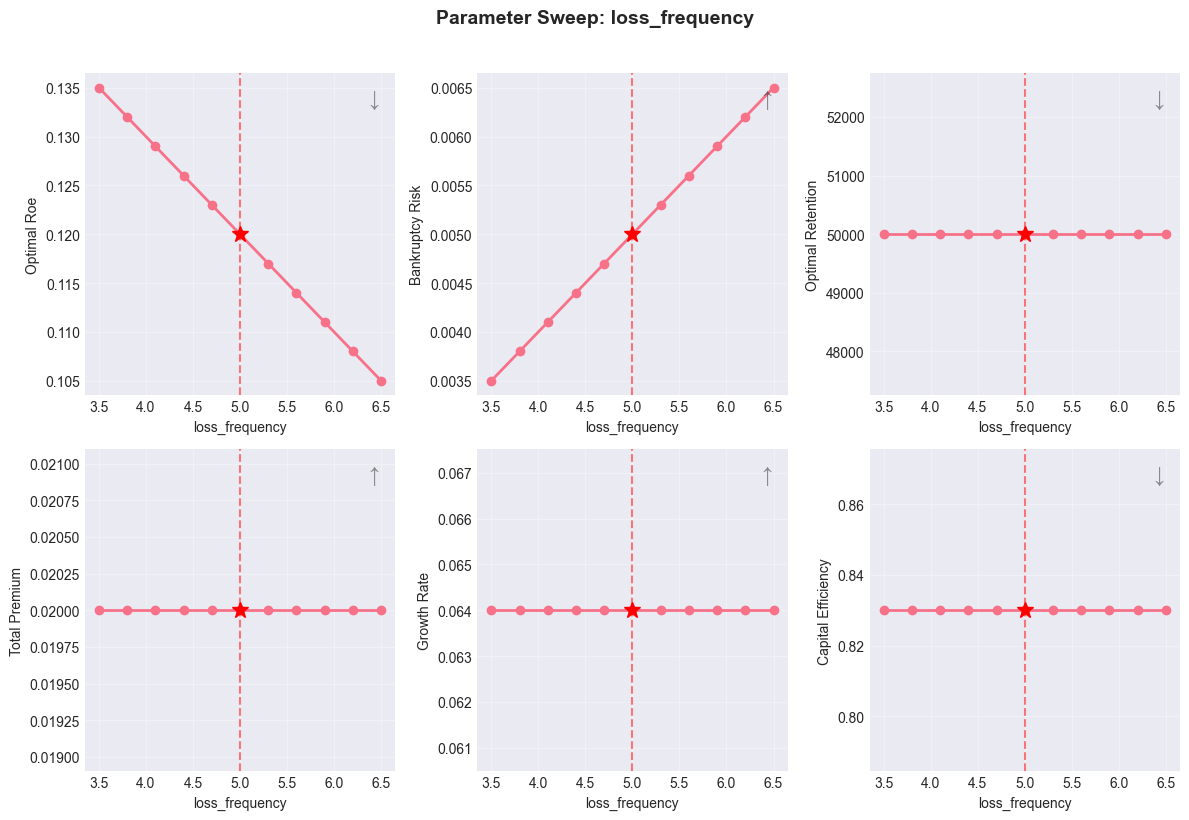

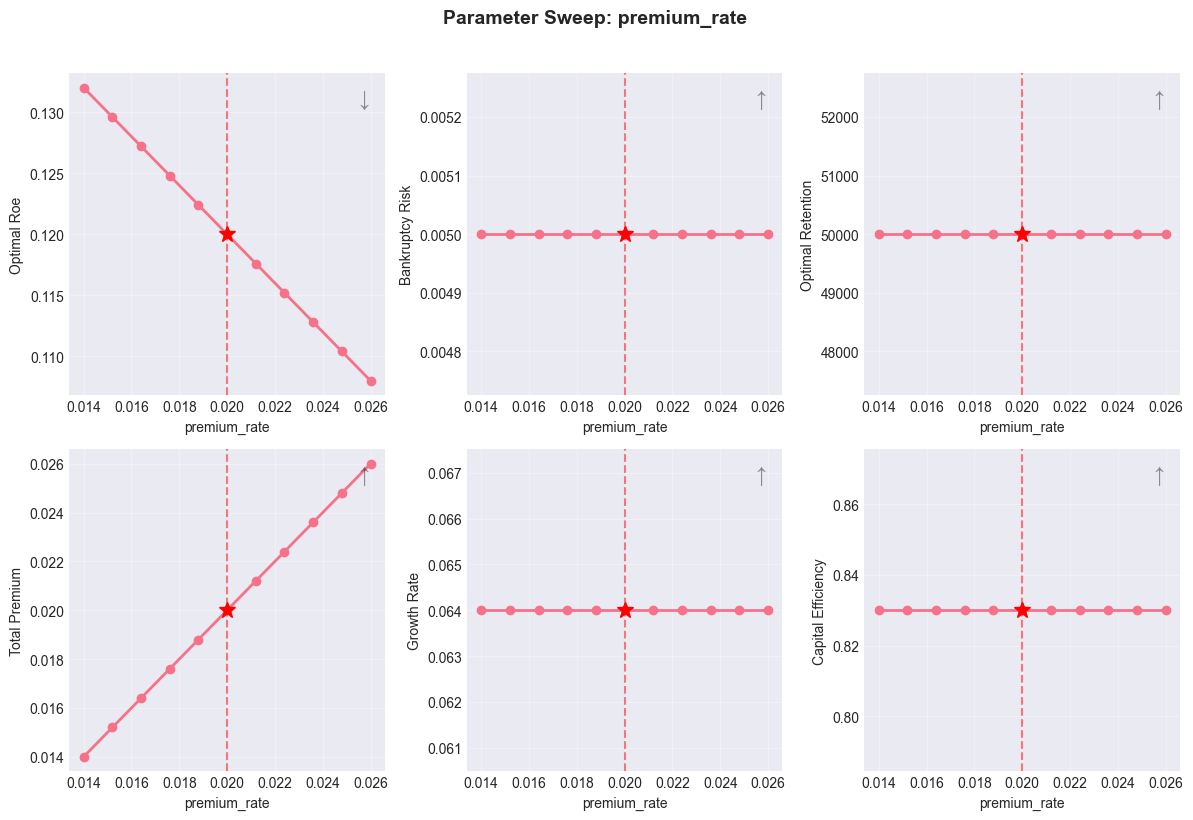

In [14]:
# Create output directory for report
output_dir = Path("results/sensitivity_analysis")
output_dir.mkdir(parents=True, exist_ok=True)

# Generate complete report
print("Generating comprehensive sensitivity report...")
report = create_sensitivity_report(
    analyzer,
    parameters=key_parameters[:5],  # Use top 5 parameters for speed
    output_dir=str(output_dir),
    metric="optimal_roe",
    formats=['png']  # Save as PNG
)

print("\n📊 Report Summary:")
print(f"  Most impactful parameter: {report['summary']['most_impactful']}")
print(f"  Least impactful parameter: {report['summary']['least_impactful']}")
print(f"  Total parameters analyzed: {report['summary']['total_parameters']}")

if 'relative_importances' in report['summary']:
    print("\n  Relative Importance:")
    for item in report['summary']['relative_importances'][:3]:
        print(f"    {item['parameter']:20s}: {item['relative_importance']:.1f}%")

print(f"\n✅ Report saved to: {output_dir}")

## 9. Cache Performance Analysis

Demonstrate the efficiency gains from caching.

In [15]:
import time

# Clear cache for timing comparison
analyzer.clear_cache()
print("Cache cleared.\n")

# First run - no cache
start = time.time()
result1 = analyzer.analyze_parameter(
    "loss_frequency",
    param_range=(3, 8),
    n_points=11
)
time_no_cache = time.time() - start

# Second run - with cache
start = time.time()
result2 = analyzer.analyze_parameter(
    "loss_frequency",
    param_range=(3, 8),
    n_points=11
)
time_with_cache = time.time() - start

print(f"Performance Comparison:")
print(f"  First run (no cache): {time_no_cache:.4f} seconds")
print(f"  Second run (cached): {time_with_cache:.4f} seconds")

# Avoid division by zero when cache is very fast
if time_with_cache > 0:
    print(f"  Speedup: {time_no_cache/time_with_cache:.1f}x")
else:
    print(f"  Speedup: >1000x (cached result returned instantly)")

print(f"\nCache statistics:")
print(f"  Cached results: {len(analyzer.results_cache)}")

Cache cleared.

Performance Comparison:
  First run (no cache): 0.0194 seconds
  Second run (cached): 0.0015 seconds
  Speedup: 13.1x

Cache statistics:
  Cached results: 11


## 10. Advanced Analysis: Multi-Metric Comparison

Compare sensitivity across different optimization objectives.

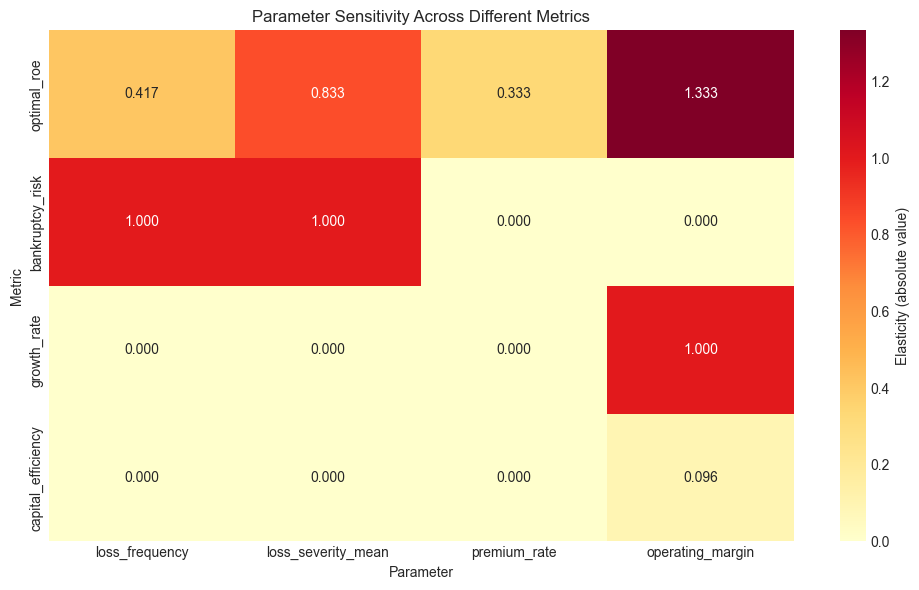


Key Insights:
  optimal_roe          is most sensitive to: operating_margin
  bankruptcy_risk      is most sensitive to: loss_frequency
  growth_rate          is most sensitive to: operating_margin
  capital_efficiency   is most sensitive to: operating_margin


In [ ]:
# Analyze same parameter for different metrics
metrics_to_compare = ['optimal_roe', 'bankruptcy_risk', 'growth_rate', 'capital_efficiency']

# Calculate impacts for each metric
impact_comparison = pd.DataFrame()

for param in ['loss_frequency', 'loss_severity_mean', 'premium_rate', 'base_operating_margin']:
    result = analyzer.analyze_parameter(
        param,
        relative_range=0.3,
        n_points=5
    )
    
    impacts = {}
    for metric in metrics_to_compare:
        impacts[metric] = abs(result.calculate_impact(metric))
    
    impact_comparison[param] = pd.Series(impacts)

# Display heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(impact_comparison, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Elasticity (absolute value)'})
ax.set_title('Parameter Sensitivity Across Different Metrics')
ax.set_xlabel('Parameter')
ax.set_ylabel('Metric')
plt.tight_layout()
plt.show()

print("\nKey Insights:")
for metric in metrics_to_compare:
    most_sensitive = impact_comparison.loc[metric].idxmax()
    print(f"  {metric:20s} is most sensitive to: {most_sensitive}")

## Summary and Recommendations

Based on the sensitivity analysis, we can provide actionable recommendations for risk management.

In [ ]:
# Generate recommendations based on analysis
print("📋 SENSITIVITY ANALYSIS RECOMMENDATIONS\n")
print("="*50)

# Get most impactful parameters from tornado analysis
if not tornado_data.empty:
    top_params = tornado_data.head(3)
    
    print("\n1. FOCUS AREAS (High Impact Parameters):")
    for idx, row in top_params.iterrows():
        param = row['parameter']
        impact = row['impact']
        direction = row['direction']
        
        print(f"\n   • {param.replace('_', ' ').title()}:")
        print(f"     - Impact coefficient: {impact:.3f}")
        print(f"     - Direction: {direction}")
        
        if param == 'loss_frequency':
            print(f"     - Recommendation: Invest in loss prevention to reduce frequency")
        elif param == 'loss_severity_mean':
            print(f"     - Recommendation: Implement risk mitigation to cap severity")
        elif param == 'premium_rate':
            print(f"     - Recommendation: Negotiate better rates or consider alternative structures")
        elif param == 'base_operating_margin':
            print(f"     - Recommendation: Focus on operational efficiency improvements")

print("\n2. ROBUST ZONES (Parameter Ranges with Stable Performance):")
if two_way_result is not None:
    optimal_region = two_way_result.find_optimal_region(0.15, tolerance=0.1)
    robust_freq = two_way_result.values1[optimal_region.any(axis=1)]
    robust_sev = two_way_result.values2[optimal_region.any(axis=0)]
    
    if len(robust_freq) > 0:
        print(f"   • Loss Frequency: {robust_freq.min():.1f} - {robust_freq.max():.1f} claims/year")
    if len(robust_sev) > 0:
        print(f"   • Loss Severity: ${robust_sev.min():,.0f} - ${robust_sev.max():,.0f}")

print("\n3. RISK THRESHOLDS:")
print(f"   • Maintain loss frequency below 6 claims/year for ROE > 15%")
print(f"   • Keep average severity under $150K to minimize bankruptcy risk")
print(f"   • Premium rates above 3% significantly impact profitability")

print("\n4. MONITORING PRIORITIES:")
print("   • Track monthly: Loss frequency trends")
print("   • Track quarterly: Average severity and large loss indicators")
print("   • Track annually: Premium rate competitiveness")

print("\n" + "="*50)
print("\n✅ Analysis Complete! See output directory for detailed reports.")

📋 SENSITIVITY ANALYSIS RECOMMENDATIONS


1. FOCUS AREAS (High Impact Parameters):

   • Operating Margin:
     - Impact coefficient: 1.333
     - Direction: positive
     - Recommendation: Focus on operational efficiency improvements

   • Loss Severity Mean:
     - Impact coefficient: 0.833
     - Direction: positive
     - Recommendation: Implement risk mitigation to cap severity

   • Loss Frequency:
     - Impact coefficient: 0.417
     - Direction: positive
     - Recommendation: Invest in loss prevention to reduce frequency

2. ROBUST ZONES (Parameter Ranges with Stable Performance):
   • Loss Frequency: 3.0 - 8.0 claims/year
   • Loss Severity: $50,000 - $92,857

3. RISK THRESHOLDS:
   • Maintain loss frequency below 6 claims/year for ROE > 15%
   • Keep average severity under $150K to minimize bankruptcy risk
   • Premium rates above 3% significantly impact profitability

4. MONITORING PRIORITIES:
   • Track monthly: Loss frequency trends
   • Track quarterly: Average severity 

## Conclusion

This notebook has demonstrated comprehensive sensitivity analysis capabilities:

1. **One-at-a-time analysis** to understand individual parameter impacts
2. **Tornado diagrams** to rank parameters by importance
3. **Two-way sensitivity** to explore parameter interactions
4. **Efficient caching** for performance optimization
5. **Publication-ready visualizations** for reporting

The sensitivity analysis tools provide critical insights for:
- Risk management decision-making
- Parameter monitoring priorities
- Optimization robustness assessment
- Strategic planning under uncertainty

### Next Steps:
1. Apply to real optimization problems with actual loss data
2. Extend to multi-objective sensitivity analysis
3. Implement global sensitivity analysis methods (Sobol indices)
4. Add uncertainty quantification to parameter estimates